# Using Multivariate Gaussian NGBoost (MVN NGBoost)

This notebook outlines using MVN NGBoost for predicting response vectors for simulated and real world data. This notebook draws upon [O'Malley et al. 2023](https://www.cambridge.org/core/journals/environmental-data-science/article/probabilistic-prediction-of-oceanographic-velocities-with-multivariate-gaussian-natural-gradient-boosting/F26F2BD51213758208B0EBAE51D1A973#article) and the supplementary materials they have provided.

In [1]:
# import packages
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('models'), '..')))
import pandas as pd
import numpy as np
from seaducks.models._mvn_ngboost import MVN_ngboost
import scipy.stats as stats
import matplotlib.pyplot as plt

# configure plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.style.use('ggplot')

# Simulated Example

In this example, following the work of O'Malley et al. (2023), we generate synthetic data according to: 

$$\begin{aligned}
\mathbf{X}_{i} & \stackrel{\text { IID }}{\sim} \text { Uniform }(0, \pi) \\
\mathbf{Y}_{i} \mid \mathbf{X}_{i} & \sim \mathbb{N}\left(\left[\begin{array}{l}
\mu_{1}\left(\mathbf{X}_{i}\right) \\
\mu_{2}\left(\mathbf{X}_{i}\right)
\end{array}\right],\left[\begin{array}{cc}
\sigma_{1}^{2}\left(\mathbf{X}_{i}\right) & \sigma_{1}\left(\mathbf{X}_{i}\right) \sigma_{2}\left(\mathbf{X}_{i}\right) \rho\left(\mathbf{X}_{i}\right) \\
\sigma_{1}\left(\mathbf{X}_{i}\right) \sigma_{2}\left(\mathbf{X}_{i}\right) \rho\left(\mathbf{X}_{i}\right) & \sigma_{2}^{2}\left(\mathbf{X}_{i}\right),
\end{array}\right]\right)
\end{aligned}$$

where

$$
\begin{aligned}
\mu_{1}(x) & =\sin (2.5 x) \sin (1.5 x)+x, \\
\mu_{2}(x) & =\cos (3.5 x) \cos (0.5 x)-x^{2}, \\
\sigma_{1}^{2}(x) & =0.01+0.25[1-\sin (2.5 x)]^{2}, \\
\sigma_{2}^{2}(x) & =0.01+0.25[1-\cos (3.5 x)]^{2}, \\
\rho(x) & =\sin (2.5 x) \cos (0.5 x) .
\end{aligned}
$$

In [26]:
def means(x,multiplier):
    return multiplier*np.sin(2.5*x)*np.sin(1.5*x) + x, multiplier*np.cos(3.5*x)*np.cos(0.5*x) - x**2

def variances(x,multiplier,additive):
    return additive + multiplier*(1-np.sin(2.5*x))**2, additive + multiplier*(1-np.cos(3.5*x))**2

def correlation(x):  
    return np.sin(2.5*x)*np.cos(0.5*x)

# -------------------------------------------------------- #

def covariance_matrix(x, multiplier, additive):
    var1,var2 = variances(x, multiplier, additive)
    cov = correlation(x)*np.sqrt(var1*var2)
    return [np.array([[var1_val, cov_val],[cov_val, var2_val]]) for var1_val, var2_val,cov_val in zip(var1,var2,cov)]

def mean_vector(x, multiplier):
    mean1,mean2 = means(x,multiplier)
    return [np.array([val1,val2]) for val1,val2 in zip(mean1,mean2)]

In [3]:
def simulate_data(N, sort=False, multiplier = 0.25, additive = 0.01):
    x = np.random.rand(N) * np.pi
    if sort:
        x = np.sort(x)
    mean = mean_vector(x,multiplier=multiplier)
    cov = covariance_matrix(x, multiplier=multiplier, additive=additive)
    dists = [stats.multivariate_normal(mean_val,cov_val) for mean_val,cov_val in zip(mean,cov)]
    y = np.array([dist.rvs(1) for dist in dists])

    return x.reshape(-1, 1) , y, dists
  

In [4]:
# simulate 10000 training and 1000 validation data points
N_train = 10000
N_val = 1000
max_boosting_iter = 1000
early_stopping_rounds = 50

X, Y, true_dist = simulate_data(N_train)
X_val, Y_val, _ = simulate_data(N_val)

In [5]:
# initialise and fit mvn ngboost model
multivariate_ngboost = MVN_ngboost(n_estimators=max_boosting_iter,early_stopping_rounds=early_stopping_rounds)
multivariate_ngboost.fit(X,Y,X_val,Y_val)
pred_y_dist = multivariate_ngboost.pred_dist(X, max_iter=multivariate_ngboost.best_val_loss_itr)

[iter 0] loss=3.4891 val_loss=3.4799 scale=1.0000 norm=2.9752
[iter 100] loss=2.1419 val_loss=2.1393 scale=2.0000 norm=2.2902
[iter 200] loss=1.3611 val_loss=1.3709 scale=2.0000 norm=2.3686
[iter 300] loss=0.9127 val_loss=0.9438 scale=2.0000 norm=3.1356
[iter 400] loss=0.7184 val_loss=0.7801 scale=2.0000 norm=4.3157
[iter 500] loss=0.6734 val_loss=0.7562 scale=0.5000 norm=1.2523
[iter 600] loss=0.6604 val_loss=0.7549 scale=1.0000 norm=2.6940
== Early stopping achieved.
== Best iteration / VAL607 (val_loss=0.7547)


In [6]:
# plot distributions
plot_x = [x[0] for x in X]
plot_x.sort()

# prediction summaries
ordered_indices = np.argsort(X.flatten())
mean = np.array([pred_y_dist.mean()[ii] for ii in ordered_indices])
cov = np.array([pred_y_dist.cov[ii] for ii in ordered_indices])
s11,s22, s12 = cov[:,0,0], cov[:,1,1], cov[:,0,1]

# true values
true_mean = np.array([true_dist[ii].mean for ii in ordered_indices])
true_cov = np.array([true_dist[ii].cov for ii in ordered_indices])
true_s11, true_s22, true_s12 = true_cov[:,0,0], true_cov[:,1,1], true_cov[:,0,1]


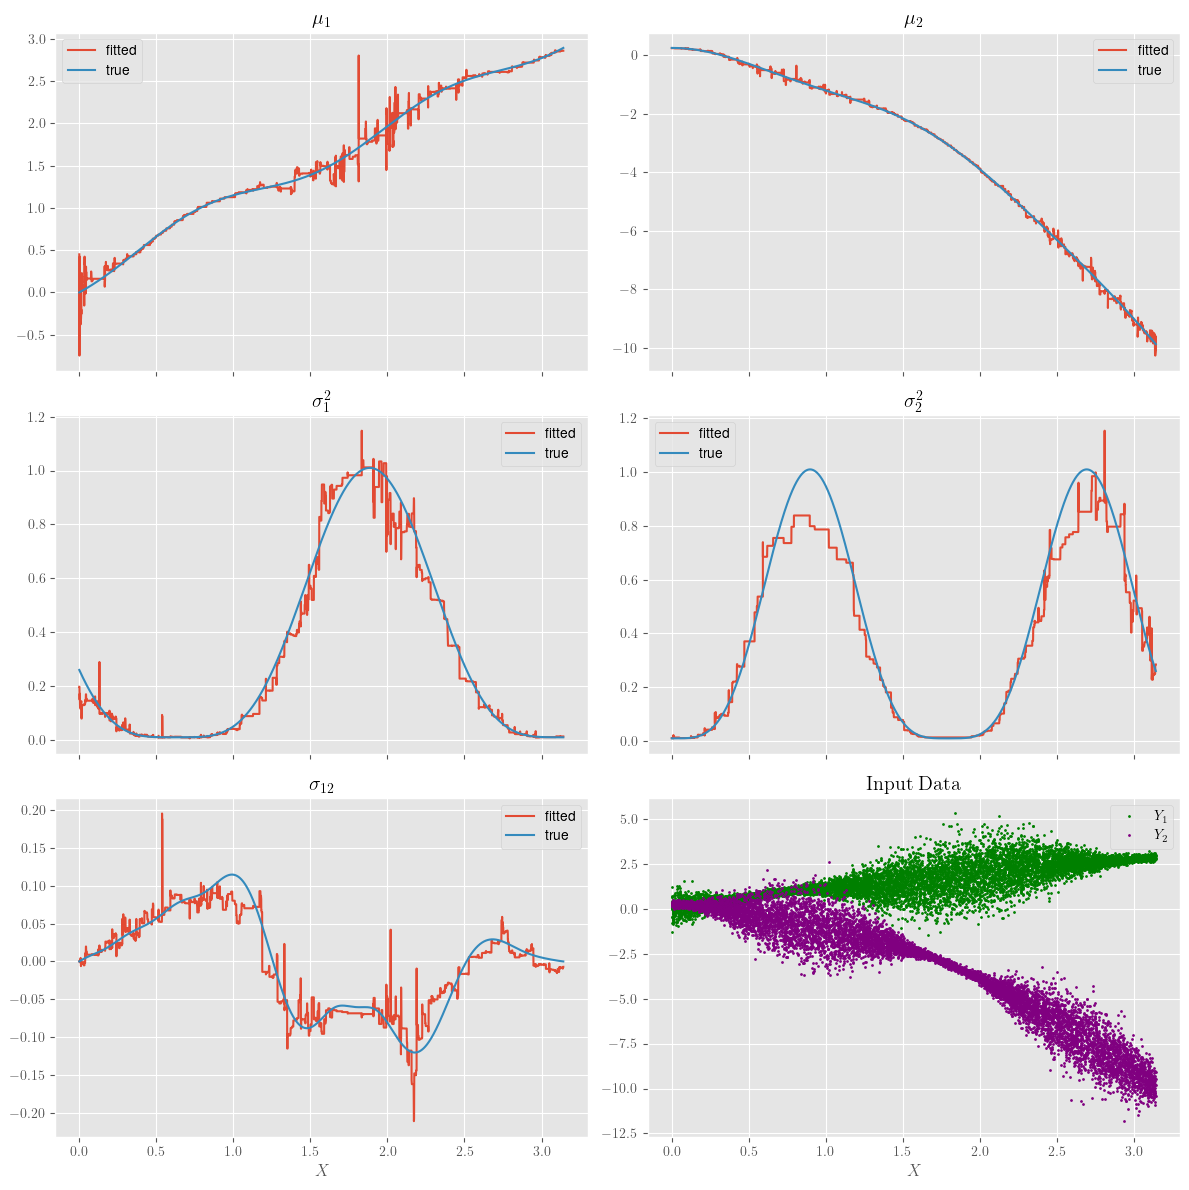

In [27]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize = (12,12))
vars = [s11,s22]
true_vars = [true_s11,true_s22]

for ii in range(2):
    # set x labels
    ax[2,ii].set_xlabel('$X$')
    # set titles
    ax[0,ii].set_title(fr'$\mu_{ii+1}$')
    ax[1,ii].set_title(fr'$\sigma^2_{ii+1}$')
    # plot values
    ## mean
    ax[0,ii].plot(plot_x, mean[:,ii], label="fitted")
    ax[0,ii].plot(plot_x, true_mean[:,ii], label="true")
    ## variances
    ax[1,ii].plot(plot_x,vars[ii],label="fitted")
    ax[1,ii].plot(plot_x,true_vars[ii],label="true")

# set titles
ax[2,0].set_title(r'$\sigma_{12}$')
ax[2,1].set_title(r'$\mathrm{Input}$ $\mathrm{Data}$')

# plot values
ax[2,0].plot(plot_x, s12, label="fitted")
ax[2,0].plot(plot_x, true_s12, label="true")
ax[2,1].plot(X, Y[:, 0], "o", label="$Y_1$", markersize=1, c='green')
ax[2,1].plot(X, Y[:, 1], "o", label="$Y_2$",markersize=1, c='purple')

for ii in range(3):
    for jj in range(2):
        ax[ii,jj].legend()
        
fig.tight_layout()
plt.show()

# Drifter Velocity Prediction

In [2]:
# load spatial plot modules
from seaducks import assign_each_position_a_bin
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable


# load data
path_to_data = r'C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\data\filtered_nao_drifters_with_sst_gradient.h5'
full_data = pd.read_hdf(path_to_data)
# add day of the year as an index (to be added to the data later)
full_data['day_of_year'] = full_data['time'].apply(lambda t : t.timetuple().tm_yday)

# separate into explanatory and response variables
explanatory_var_labels = ['u_av','v_av','lat','lon','day_of_year','Wx','Wy','Tx','Ty','sst_x_derivative','sst_y_derivative']
response_var_labels = ['u','v']

In [20]:
data = full_data.head(20000)

In [39]:
early_stopping_rounds = 50
max_boosting_iter = 1000
# the rest of the settings are defaults.
file_name = '_20000_data_points'
multivariate_ngboost = MVN_ngboost(n_estimators=max_boosting_iter,early_stopping_rounds=early_stopping_rounds)
multivariate_ngboost.run_model_and_save(data,explanatory_var_labels,response_var_labels,file_name)

[iter 0] loss=-0.0131 val_loss=-0.1431 scale=0.1250 norm=0.3887
[iter 100] loss=-0.8952 val_loss=-0.9368 scale=2.0000 norm=4.2735
[iter 200] loss=-1.2887 val_loss=-1.3177 scale=1.0000 norm=3.4558
[iter 300] loss=-1.4057 val_loss=-1.4236 scale=1.0000 norm=4.2677
[iter 400] loss=-1.4697 val_loss=-1.4713 scale=1.0000 norm=4.8708
[iter 500] loss=-1.5124 val_loss=-1.5020 scale=1.0000 norm=5.2653
[iter 600] loss=-1.5470 val_loss=-1.5249 scale=1.0000 norm=5.5195
[iter 700] loss=-1.5729 val_loss=-1.5366 scale=1.0000 norm=5.7058
[iter 800] loss=-1.5929 val_loss=-1.5450 scale=1.0000 norm=5.8216
[iter 900] loss=-1.6115 val_loss=-1.5510 scale=1.0000 norm=5.9037


In [40]:
multivariate_ngboost.save_model('_20000_data_points_mvn_ngboost_')

In [58]:
import pickle
with open('_20000_data_pointstest_data.p', 'rb') as pickle_file:
    content = pickle.load(pickle_file)

with open('_20000_data_points_mvn_ngboost_.p', 'rb') as pickle_file:
    small_model = pickle.load(pickle_file)

In [33]:
def rmse(vec1,vec2):
    return np.sqrt(np.mean(np.square(vec1-vec2)))

In [43]:

predicted_distribution = content[1]
testing_data = content[0]
locs, covs = predicted_distribution
testing_data.loc[:,'mvn_ngb_prediction_u'] = locs[:,0]
testing_data.loc[:,'mvn_ngb_prediction_v'] = locs[:,1]

In [71]:
# evaluate full model
all_data = full_data.copy()
pred_dists = small_model.scipy_distribution(all_data[explanatory_var_labels],cmat_output = True)
full_locs, full_covs = pred_dists

all_data.loc[:,'mvn_ngb_prediction_u'] = full_locs[:,0]
all_data.loc[:,'mvn_ngb_prediction_v'] = full_locs[:,1]
all_data.loc[:,'maao'] = all_data.apply(lambda row: np.rad2deg(np.arccos(np.dot(np.array(row[['mvn_ngb_prediction_u','mvn_ngb_prediction_v']]),np.array(row[['u','v']]))/
                                                                         (np.linalg.norm(np.array(row[['mvn_ngb_prediction_u','mvn_ngb_prediction_v']]))*np.linalg.norm(np.array(row[['u','v']]))))),axis=1)


In [72]:
rmse_val = 100*rmse(np.array(testing_data[['u','v']]),np.array(testing_data[['mvn_ngb_prediction_u','mvn_ngb_prediction_v']]))
# calculate MAAO for each prediction
maao =  testing_data.apply(lambda row: np.rad2deg(np.arccos(np.dot(np.array(row[['mvn_ngb_prediction_u','mvn_ngb_prediction_v']]),
                                                                   np.array(row[['u','v']]))/(np.linalg.norm(row[['mvn_ngb_prediction_u','mvn_ngb_prediction_v']])*np.linalg.norm(np.array(row[['u','v']]))))),axis=1)

In [73]:
print(f"\n MAAO: {maao.mean():.2f} degrees")
print(f"\n RMSE: {rmse_val:.2f} cm/s")


 MAAO: 47.90 degrees

 RMSE: 15.16 cm/s


In [74]:
fi=multivariate_ngboost.feature_importances_
params = ['mu_x', 'mu_y', 'a_11', 'a_12','a_22']

for jj,param in enumerate(params):
    print(f'\nFeature Importances for {param}')
    for ii, var in enumerate(explanatory_var_labels):
        print(f"{var}: {fi[jj][ii]}")


Feature Importances for mu_x
u_av: 0.26114206025090825
v_av: 0.08177925830403193
lat: 0.2079929903776698
lon: 0.14857023552130913
day_of_year: 0.03412457575460986
Wx: 0.027868106515736603
Wy: 0.031681528575480684
Tx: 0.03615983523999241
Ty: 0.04980786128462656
sst_x_derivative: 0.016206835418065783
sst_y_derivative: 0.10466671275756895

Feature Importances for mu_y
u_av: 0.042463036355179014
v_av: 0.2865202265029226
lat: 0.18854922976808872
lon: 0.19756696709583949
day_of_year: 0.0321483392187612
Wx: 0.04108044792130448
Wy: 0.02444452505728612
Tx: 0.03625519478067139
Ty: 0.029262323789375485
sst_x_derivative: 0.08597027436987564
sst_y_derivative: 0.035739435140695906

Feature Importances for a_11
u_av: 0.13266667734208176
v_av: 0.09823963028606429
lat: 0.2834916088093085
lon: 0.20200389355887213
day_of_year: 0.08763053331725629
Wx: 0.022152623618041954
Wy: 0.014317423419427521
Tx: 0.01612844043318695
Ty: 0.02372037852609199
sst_x_derivative: 0.03352952185540949
sst_y_derivative: 0.086

In [75]:
# spatial plotting functions

def cuts2poly(tuple_tuple) -> Polygon:
    """

    Args:
        tuple_tuple: a tuple of pd cuts, designed for .groupby([lon_cut, lat_cut]) operations
    Returns:
         a Shapely Polygon containing the square resulting from the cuts.
    """
    lon, lat = tuple_tuple
    lon1, lon2 = lon.left, lon.right
    lat1, lat2 = lat.left, lat.right
    return Polygon(np.array([(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]))

def add_gridlines(ax, xlocs = [-85, -70, -55, -40],
                      ylocs = list(range(0,66,15))):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray',
                      alpha=0.5, linestyle='--', 
                      
                     )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines=False
    gl.xlocator = mticker.FixedLocator(xlocs)
    gl.ylocator = mticker.FixedLocator(ylocs)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

def plot_column(daf, column, ax, cmap='seismic', vmin_manual=None, vmax_manual=None):
    vmin, vmax =daf[column].min(), daf[column].max()
    changed_vmin, changed_vmax = False, False
    if vmin_manual is not None:
        changed_vmin = vmin!=vmin_manual
        vmin = vmin_manual
    if vmax_manual is not None:
        changed_vmax = vmax!=vmax_manual
        vmax = vmax_manual
        #norm = mpl.colors.LogNorm(vmin=daf[column].min(), vmax=daf[column].max())
    extend="neither"
    if changed_vmin:
        if changed_vmax:
            extend="both"
        else:
            extend="min"
    else:
        if changed_vmax:
            extend="max"
        
    
    if cmap == 'seismic':
        norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0,vmax=vmax)
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
    f = ax.get_figure()
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',
                                   extend=extend)
    f.add_axes(cax)
    crs = ccrs.PlateCarree()
    for color, rows in daf.groupby(column):
        color_mapped = sm.cmap(norm(color))
        ax.add_geometries(
            rows["geometry"], crs=crs, facecolor=color_mapped, edgecolor=color_mapped
        )
    return cax

def add_letters(axs):
    for n, ax in enumerate(axs.flatten()):
        ax.text(-0.26, 0.5, '', transform=ax.transAxes, 
            size=13, weight='bold')

def err_df(drifter_dataset,lat_grid,lon_grid,bin_size):
    '''
    Creates a dataframe with the same indices as drifter_dataset 
    '''

    # bin the domain 
    df = assign_each_position_a_bin(drifter_dataset,lat_grid, lon_grid, bin_size=bin_size)
    vars = df.columns

    # initialise 
    ## set indices
    idx = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda x:x).index
    idx = np.array([ii for ii in idx])
    idx0 = [ii[0] for ii in idx]
    idx1 = [ii[1] for ii in idx]

    plot_frame = pd.DataFrame(index=[idx0,idx1])
    
    # with sst
    plot_frame.loc[:,'rmse'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda row: 100*np.sqrt(np.mean(np.square(np.array(row[['u','v']]) - np.array(row[['mvn_ngb_prediction_u','mvn_ngb_prediction_v']])))))
    plot_frame.loc[:,'maao'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda x :np.mean(x['maao']))  

    plot_frame.dropna(inplace=True)
    gpd = list(map(cuts2poly,plot_frame.index))
    plot_frame['geometry']=gpd

    # add average longitudes and latitudes
    lons = np.array([(idx[0].left +idx[0].right)/2 for idx in plot_frame.index])
    lats = np.array([(idx[1].left +idx[1].right)/2 for idx in plot_frame.index])
    plot_frame['longitude'] = lons
    plot_frame['latitude'] = lats

    return plot_frame

In [76]:
# create error dataset

bin_size = 0.2
lat_grid = np.arange(-90,90 + bin_size,bin_size)
lon_grid = np.arange(-180,180 + bin_size,bin_size)

errs = err_df(all_data,lat_grid,lon_grid,bin_size)

C:\Users\vm2218\AppData\Local\Temp\ipykernel_22300\3729320383.py:99: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_frame.loc[:,'rmse'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda row: 100*np.sqrt(np.mean(np.square(np.array(row[['u','v']]) - np.array(row[['mvn_ngb_prediction_u','mvn_ngb_prediction_v']])))))
C:\Users\vm2218\AppData\Local\Temp\ipykernel_22300\3729320383.py:100: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_frame.loc[:,'maao'] = df.groupby([f"lon_bin_size_{bin_size}", f"lat_bin_size_{bin_size}"], sort=False, observed=False)[vars].apply(lambda x :np.mean(x['maao']))


In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5), subplot_kw= {"projection":ccrs.PlateCarree()})
metric_names = ['rmse','maao']
titles = ['rmse', 'maao']
cbar_names = [r"cm/s", r"degrees"]
extent = [-85.01,#summaries['lon'].min(),
          data['lon'].max(),
          -0.01,
          data['lat'].max()
         ]

print('fig successful')
for i, metric in enumerate(metric_names):
    col = int(i%2)
    row = int((i-col)/2)
    current_ax = axs[col]
    if metric == 'rmse':
        vmax_manual = 140
    elif metric == 'maao':
        vmax_manual = None
    cax = plot_column(errs,
                      metric,
                      ax=current_ax,
                      cmap='Reds',vmax_manual=vmax_manual)
    print(f'{metric} plot successful')
    current_ax.set_title(titles[i])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(current_ax)
    cax.set_ylabel(cbar_names[i], labelpad=0.1)
    
add_letters(axs)
print('letters added')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
#axs[1,1].quiver(spatial_summaries['lon'], spatial_summaries['lat'], spatial_summaries['mean_lon'], spatial_summaries['mean_lat'], zorder=15)
axs[1].coastlines()
axs[1].set_aspect('auto')
#axs[1,1].set_title("Mean Predicted Velocity")
#fig.tight_layout()

plt.show()

fig successful
